# Setup and Imports

In [ ]:
!nvidia-smi

Fri Jan 17 19:15:51 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms, models, datasets
from torchsummary import summary
import numpy as np, pandas as pd, os, glob, cv2
from torch.utils.data import TensorDataset,DataLoader,Dataset
from copy import deepcopy
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.ticker as mticker
from sklearn import cluster
from sklearn.model_selection import train_test_split
%matplotlib inline

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Data Loading

In [ ]:
!git clone https://github.com/udacity/P1_Facial_Keypoints.git
!cd P1_Facial_Keypoints
root_dir = 'P1_Facial_Keypoints/data/training/'
all_img_paths = glob.glob(os.path.join(root_dir, '*.jpg'))

Cloning into 'P1_Facial_Keypoints'...
remote: Enumerating objects: 6049, done.
remote: Total 6049 (delta 0), reused 0 (delta 0), pack-reused 6049 (from 1)
Receiving objects: 100% (6049/6049), 329.52 MiB | 16.57 MiB/s, done.
Resolving deltas: 100% (157/157), done.
Updating files: 100% (5805/5805), done.


In [ ]:
data = pd.read_csv('P1_Facial_Keypoints/data/training_frames_keypoints.csv')

In [ ]:
data.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,135
0,Luis_Fonsi_21.jpg,45.0,98.0,47.0,106.0,49.0,110.0,53.0,119.0,56.0,...,83.0,119.0,90.0,117.0,83.0,119.0,81.0,122.0,77.0,122.0
1,Lincoln_Chafee_52.jpg,41.0,83.0,43.0,91.0,45.0,100.0,47.0,108.0,51.0,...,85.0,122.0,94.0,120.0,85.0,122.0,83.0,122.0,79.0,122.0
2,Valerie_Harper_30.jpg,56.0,69.0,56.0,77.0,56.0,86.0,56.0,94.0,58.0,...,79.0,105.0,86.0,108.0,77.0,105.0,75.0,105.0,73.0,105.0
3,Angelo_Reyes_22.jpg,61.0,80.0,58.0,95.0,58.0,108.0,58.0,120.0,58.0,...,98.0,136.0,107.0,139.0,95.0,139.0,91.0,139.0,85.0,136.0
4,Kristen_Breitweiser_11.jpg,58.0,94.0,58.0,104.0,60.0,113.0,62.0,121.0,67.0,...,92.0,117.0,103.0,118.0,92.0,120.0,88.0,122.0,84.0,122.0


# Data Preprocessing

In [ ]:
class FacesData(Dataset):

  def __init__(self, df):
    super(FacesData).__init__() # Initializes the pytorch's Dataset package; ensuring that any necessary setup in the parent Dataset class is performed.
    self.df = df
    self.normalize = transforms.Normalize(
      mean=[0.485, 0.456, 0.406],
      std=[0.229, 0.224, 0.225]
    ) # The mean and std values are typical for images from the ImageNet dataset (used during training of pre-trained models like VGG16).

  # Helps the input images match the distribution of the dataset used to train pre-trained models. This improves performance and convergence during training.

  def __len__(self):
    return len(self.df)

  def __getitem__(self, ix):
    img_path = root_dir + self.df.iloc[ix, 0]
    img = cv2.imread(img_path) / 255.  # Scaling
    img = cv2.resize(img, (224, 224))  # Resizing

    kp = deepcopy(self.df.iloc[ix, 1:].tolist())
    kp_x = (np.array(kp[0::2]) / 224).tolist()  # Normalizing relative to resized dimensions
    kp_y = (np.array(kp[1::2]) / 224).tolist()

    kp2 = kp_x + kp_y
    kp2 = torch.tensor(kp2)

    img = self.preprocess_input(img)

    return img, kp2


  def preprocess_input(self, img):
    # img = cv2.resize(img, (224,224))
    img = torch.tensor(img).permute(2,0,1)  # Changes the shape from (height, width, channels) (HWC, typical for OpenCV) to (channels, height, width) (CHW, required for PyTorch models).
    img = self.normalize(img).float()

    return img.to(device)

  def load_img(self, ix):
    img_path = 'P1_Facial_Keypoints/data/training/' + self.df.iloc[ix, 0]
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)/255.
    img = cv2.resize(img, (224,224))

    return img

# Model Architecture

In [ ]:
def get_model():
    model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

    for param in model.parameters():
        param.requires_grad = False

    model.avgpool = nn.Sequential(
        nn.Conv2d(512, 512, 3),
        nn.MaxPool2d(2),
        nn.Flatten()
    )

    model.classifier = nn.Sequential(
        nn.Linear(2048, 512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, 136),
        nn.Sigmoid()
    )

    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5, weight_decay=1e-4)

    return model.to(device), criterion, optimizer

# Training and Validation

In [ ]:
def train_batch(img, kps, model, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    _kps = model(img.to(device))
    loss = criterion(_kps, kps.to(device))
    loss.backward()
    optimizer.step()

    return loss

In [ ]:
def validate_batch(img, kps, model, criterion):
    model.eval()
    _kps = model(img.to(device))
    loss = criterion(_kps, kps.to(device))

    return _kps, loss

In [ ]:
train, test = train_test_split(data, test_size=0.2, random_state=101)
train_dataset = FacesData(train.reset_index(drop=True))
test_dataset = FacesData(test.reset_index(drop=True))
train_loader = DataLoader(train_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
model, criterion, optimizer = get_model()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 174MB/s]


In [ ]:
train_loss, test_loss = [], []
n_epochs = 50

In [ ]:
import tqdm

for epoch in range(n_epochs):
  print(f"epoch {epoch + 1} : {n_epochs}")
  epoch_train_loss, epoch_test_loss = 0, 0

  print("Training...")
  for ix, (img,kps) in tqdm.tqdm_notebook(enumerate(train_loader)):
    loss = train_batch(img, kps, model, optimizer, criterion)
    epoch_train_loss += loss.item()

  epoch_train_loss /= (ix+1)

  print()

  print("Validation...")
  for ix,(img,kps) in tqdm.tqdm_notebook(enumerate(test_loader)):
    ps, loss = validate_batch(img, kps, model, criterion)
    epoch_test_loss += loss.item()

  epoch_test_loss /= (ix+1)

  train_loss.append(epoch_train_loss)
  test_loss.append(epoch_test_loss)

  print()

epoch 1 : 50
Training...


<ipython-input-14-896938dc9eba>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for ix, (img,kps) in tqdm.tqdm_notebook(enumerate(train_loader)):


0it [00:00, ?it/s]


Validation...


<ipython-input-14-896938dc9eba>:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for ix,(img,kps) in tqdm.tqdm_notebook(enumerate(test_loader)):


0it [00:00, ?it/s]


epoch 2 : 50
Training...


0it [00:00, ?it/s]


Validation...


0it [00:00, ?it/s]


epoch 3 : 50
Training...


0it [00:00, ?it/s]


Validation...


0it [00:00, ?it/s]


epoch 4 : 50
Training...


0it [00:00, ?it/s]


Validation...


0it [00:00, ?it/s]


epoch 5 : 50
Training...


0it [00:00, ?it/s]


Validation...


0it [00:00, ?it/s]


epoch 6 : 50
Training...


0it [00:00, ?it/s]


Validation...


0it [00:00, ?it/s]


epoch 7 : 50
Training...


0it [00:00, ?it/s]


Validation...


0it [00:00, ?it/s]


epoch 8 : 50
Training...


0it [00:00, ?it/s]


Validation...


0it [00:00, ?it/s]


epoch 9 : 50
Training...


0it [00:00, ?it/s]


Validation...


0it [00:00, ?it/s]


epoch 10 : 50
Training...


0it [00:00, ?it/s]


Validation...


0it [00:00, ?it/s]


epoch 11 : 50
Training...


0it [00:00, ?it/s]


Validation...


0it [00:00, ?it/s]


epoch 12 : 50
Training...


0it [00:00, ?it/s]


Validation...


0it [00:00, ?it/s]


epoch 13 : 50
Training...


0it [00:00, ?it/s]


Validation...


0it [00:00, ?it/s]


epoch 14 : 50
Training...


0it [00:00, ?it/s]


Validation...


0it [00:00, ?it/s]


epoch 15 : 50
Training...


0it [00:00, ?it/s]


Validation...


0it [00:00, ?it/s]


epoch 16 : 50
Training...


0it [00:00, ?it/s]


Validation...


0it [00:00, ?it/s]


epoch 17 : 50
Training...


0it [00:00, ?it/s]


Validation...


0it [00:00, ?it/s]


epoch 18 : 50
Training...


0it [00:00, ?it/s]


Validation...


0it [00:00, ?it/s]


epoch 19 : 50
Training...


0it [00:00, ?it/s]


Validation...


0it [00:00, ?it/s]


epoch 20 : 50
Training...


0it [00:00, ?it/s]


Validation...


0it [00:00, ?it/s]


epoch 21 : 50
Training...


0it [00:00, ?it/s]


Validation...


0it [00:00, ?it/s]


epoch 22 : 50
Training...


0it [00:00, ?it/s]


Validation...


0it [00:00, ?it/s]


epoch 23 : 50
Training...


0it [00:00, ?it/s]


Validation...


0it [00:00, ?it/s]


epoch 24 : 50
Training...


0it [00:00, ?it/s]


Validation...


0it [00:00, ?it/s]


epoch 25 : 50
Training...


0it [00:00, ?it/s]


Validation...


0it [00:00, ?it/s]


epoch 26 : 50
Training...


0it [00:00, ?it/s]


Validation...


0it [00:00, ?it/s]


epoch 27 : 50
Training...


0it [00:00, ?it/s]


Validation...


0it [00:00, ?it/s]


epoch 28 : 50
Training...


0it [00:00, ?it/s]


Validation...


0it [00:00, ?it/s]


epoch 29 : 50
Training...


0it [00:00, ?it/s]


Validation...


0it [00:00, ?it/s]


epoch 30 : 50
Training...


0it [00:00, ?it/s]


Validation...


0it [00:00, ?it/s]


epoch 31 : 50
Training...


0it [00:00, ?it/s]


Validation...


0it [00:00, ?it/s]


epoch 32 : 50
Training...


0it [00:00, ?it/s]


Validation...


0it [00:00, ?it/s]


epoch 33 : 50
Training...


0it [00:00, ?it/s]


Validation...


0it [00:00, ?it/s]


epoch 34 : 50
Training...


0it [00:00, ?it/s]


Validation...


0it [00:00, ?it/s]


epoch 35 : 50
Training...


0it [00:00, ?it/s]


Validation...


0it [00:00, ?it/s]


epoch 36 : 50
Training...


0it [00:00, ?it/s]


Validation...


0it [00:00, ?it/s]


epoch 37 : 50
Training...


0it [00:00, ?it/s]


Validation...


0it [00:00, ?it/s]


epoch 38 : 50
Training...


0it [00:00, ?it/s]


Validation...


0it [00:00, ?it/s]


epoch 39 : 50
Training...


0it [00:00, ?it/s]


Validation...


0it [00:00, ?it/s]


epoch 40 : 50
Training...


0it [00:00, ?it/s]


Validation...


0it [00:00, ?it/s]


epoch 41 : 50
Training...


0it [00:00, ?it/s]


Validation...


0it [00:00, ?it/s]


epoch 42 : 50
Training...


0it [00:00, ?it/s]


Validation...


0it [00:00, ?it/s]


epoch 43 : 50
Training...


0it [00:00, ?it/s]


Validation...


0it [00:00, ?it/s]


epoch 44 : 50
Training...


0it [00:00, ?it/s]


Validation...


0it [00:00, ?it/s]


epoch 45 : 50
Training...


0it [00:00, ?it/s]


Validation...


0it [00:00, ?it/s]


epoch 46 : 50
Training...


0it [00:00, ?it/s]


Validation...


0it [00:00, ?it/s]


epoch 47 : 50
Training...


0it [00:00, ?it/s]


Validation...


0it [00:00, ?it/s]


epoch 48 : 50
Training...


0it [00:00, ?it/s]


Validation...


0it [00:00, ?it/s]


epoch 49 : 50
Training...


0it [00:00, ?it/s]


Validation...


0it [00:00, ?it/s]


epoch 50 : 50
Training...


0it [00:00, ?it/s]


Validation...


0it [00:00, ?it/s]

In [ ]:
print(f"Length of train_loss: {len(train_loss)}, Length of test_loss: {len(test_loss)}")

Length of train_loss: 50, Length of test_loss: 50


In [ ]:
epochs = np.arange(n_epochs)+1
print(len(epochs))

50


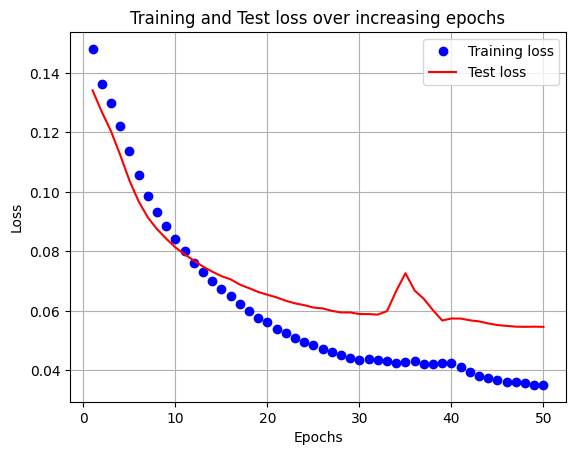

In [ ]:
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, test_loss, 'r', label='Test loss')
plt.title('Training and Test loss over increasing epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')

plt.show()

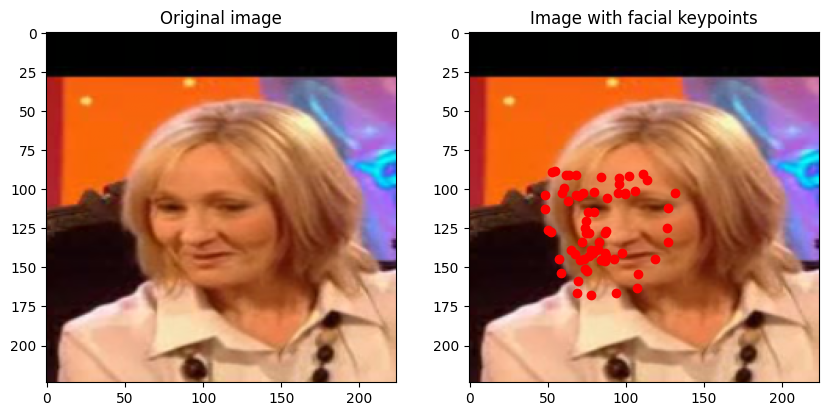

In [ ]:
ix = 0

plt.figure(figsize=(10,10))

plt.subplot(221)

plt.title('Original image')
im = test_dataset.load_img(ix)
plt.imshow(im)
plt.grid(False)
plt.subplot(222)

plt.title('Image with facial keypoints')
x, _ = test_dataset[ix]
plt.imshow(im)
kp = model(x[None]).flatten().detach().cpu()
plt.scatter(kp[:68]*224, kp[68:]*224, c='r')
plt.grid(False)

plt.show()

# Alternatively: We can implement this whole project in just few lines of code, by using the face-alignment package

### Setup and Imports

In [ ]:
!pip install -qU face-alignment

In [ ]:
import face_alignment, cv2

### Importing the Image

In [ ]:
!wget https://upload.wikimedia.org/wikipedia/commons/a/a3/June_odd-eyed-cat.jpg

--2025-01-17 19:10:36--  https://upload.wikimedia.org/wikipedia/commons/a/a3/June_odd-eyed-cat.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.153.240, 2620:0:860:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.153.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 992514 (969K) [image/jpeg]
Saving to: ‘June_odd-eyed-cat.jpg’

June_odd-eyed-cat.j 100%[===================>] 969.25K  4.06MB/s    in 0.2s    

2025-01-17 19:10:37 (4.06 MB/s) - ‘June_odd-eyed-cat.jpg’ saved [992514/992514]



### Defining the face alignment method, where we specify whether we want to fetch keypoint landmarks in 2D or 3D

In [ ]:
fa = face_alignment.FaceAlignment(
    face_alignment.LandmarksType.TWO_D,
    flip_input=False,
    device='cpu'
    )

### Reading the input image and provide it to the get_landmarks method

In [ ]:
def predictions(input_image_path):
  input = cv2.imread(input_image_path)
  preds = fa.get_landmarks(input)[0]

  # print(preds)  # For, testing
  # print(preds.shape)

  return input, preds

### Plotting the image with the detected keypoints

In [ ]:
input, preds = predictions("/content/June_odd-eyed-cat.jpg")

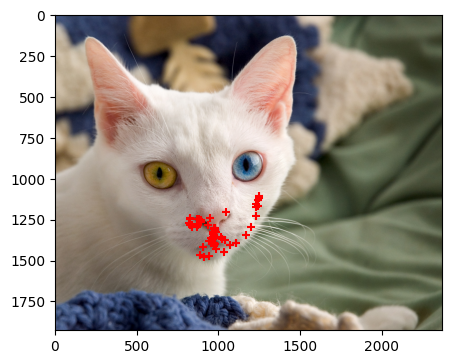

In [ ]:
fig,ax = plt.subplots(figsize=(5,5))

plt.imshow(cv2.cvtColor(input, cv2.COLOR_BGR2RGB))

ax.scatter(preds[:,0], preds[:,1], marker='+', c='r')

plt.show()

In [ ]:
input_1, preds_1 = predictions('/content/.jpg') # Upload your own image here

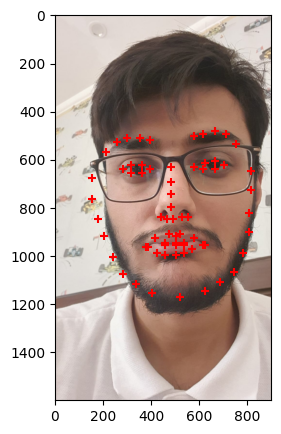

In [ ]:
fig,ax = plt.subplots(figsize=(5,5))

plt.imshow(cv2.cvtColor(input_1, cv2.COLOR_BGR2RGB))

ax.scatter(preds_1[:,0], preds_1[:,1], marker='+', c='r')

plt.show()

# As you can observe that the respective utility is unable to perform well on animal based inputs. Therefore, developing and finetuning a model in this regards is one of the future directions.